In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain.callbacks.manager import CallbackManager
from langchain_core.prompts import ChatPromptTemplate
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from typing import List, Literal
from langgraph.prebuilt import tools_condition 
from IPython.display import Image, display



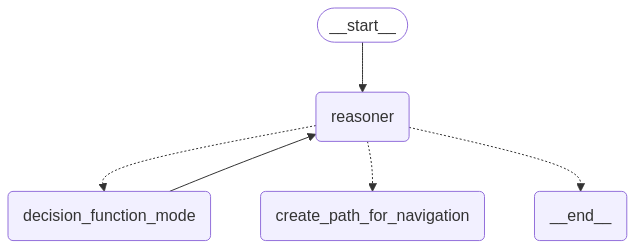

In [19]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """
You are an intelligent assistant controlling a walker. With each interaction with the user, you check to see if there is a need to change the walker’s operating mode. The goal is to continuously identify the user's intent and adjust the navigation mode accordingly. The walker has two operating modes:

- **Free Navigation**: The user walks freely without assistance.
- **Assisted Navigation**: The user wants to be guided or assisted to reach their destination.

Whenever the user makes a request, check for a clear indication that the navigation mode needs to be changed. If so, use the mode decision tool to make the switch.

If the walker is in assisted navigation mode and the user states a destination, you should use the entire user input sentence to find an appropriate path to the destination. Use the path generation tool to calculate the route and guide the user to the requested location.

If the request is for assisted navigation and the user does not indicate a destination, you should ask or wait for more details about the desired location.

Always check all sentences to identify whether the user wants to change the operating mode. If the message is informal, respond in a friendly manner, but always taking into account the required operating mode.
"""),
        ("human", "{input}"),
    ]
)

@tool
def decision_function_mode(query: str) -> str:
    """Decides the operating mode of the walker based on the user's input"""
    query = query.lower()
    print(f"Value from llm: {query}")
    if "free navigation" in query or "free mode" in query:
        return "Free navigation"
    elif "assisted navigation" in query or "assisted mode" in query:
        return "Assisted navigation"  
    return "None" 

@tool
def create_path_for_navigation(query: str) -> str:
    """Generates a path for navigation based on the user's input"""
    return f"Caminho gerado para: {query}"  

callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

# Load the LLM model
LLM_model = ChatOllama(
    model="qwen2.5:32b",
    temperature=0.0,
    num_predict=1024,
    num_ctx=8094,
    callback_manager=callback_manager,
    seed=None,
)

chain = prompt | LLM_model
tools = [decision_function_mode, create_path_for_navigation]
llm_with_tools = LLM_model.bind_tools(tools)

sys_msg = SystemMessage (content= "You are a useful assistant in charge of controlling the operating mode of a smart walker based on the intentions extracted from the user's sentence. The walker has two operating modes: free navigation (where the user does not need your help to walk) or assisted navigation (where you can assist the user by creating a safe route to the destination point if requested). If during use the user talks to you about subjects other than navigation-related commands, just respond in a friendly manner.")


def reasoner (state: MessagesState):
    
    messages = state["messages"]
    result = [llm_with_tools.invoke([sys_msg] + messages)]

    return {"messages": result}

graph = StateGraph (MessagesState)
builder =StateGraph (MessagesState)
builder.add_node(reasoner)
builder.add_node ("decision_function_mode", decision_function_mode)
builder.add_node ("create_path_for_navigation", create_path_for_navigation)
builder.add_edge(START, "reasoner")
graph.add_conditional_edges(
            "decision_function_mode", decision_function_mode,
            {"free navigation": "reasoner", "assisted navigation": "create_path_for_navigation"}
        )
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("decision_function_mode", "reasoner")
agent= builder.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
graph_image = agent.get_graph(xray=True).draw_mermaid_png()